# 01d_HSC_preprocessing_harmony_integrate

try out alternative batch correction method to combat - harmony

**Conclusion:** seems to be overcorrecting, dmPGE2 completly mixes in with 'Activated' state - defined by Nr4a2 and other IEGs. 

docker run 
--rm 
-d 
--name scanpy
-p 8881:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
scanpy:1.7.2

## Loading packages + data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

In [4]:
# Set up data loading

#Data files
sample_strings = ['ct', 'dmPGE2', 'GCSF', 'indo', 'pIC']
sample_id_strings = ['A_ct', 'A_dmPGE2', 'A_GCSF', 'A_indo', 'A_pIC']

base_path = ''

file_base = '/home/jovyan/work/Z_TRASH/raw_data/'
file_end = '/outs/filtered_feature_bc_matrix/'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0) # this pops out the first element of the list sample_strings = ct
sample_id = sample_id_strings.pop(0) # this pops out the first element of the list sample_id_strings = 1
data_file = file_base+sample_id+file_end # assembles the name of the datafile

#Load data
adata = sc.read_10x_mtx(data_file, var_names='gene_symbols', cache=True)

#Annotate data
adata.obs['sample'] = [sample]*adata.n_obs #this multiplies ct*the number of adata.n_obs and adds it into the adata.obs df

... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_ct-outs-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i] # this pops out the first element of the list sample_strings = ct
    sample_id = sample_id_strings[i] # this pops out the first element of the list sample_id_strings = 1
    data_file = file_base+sample_id+file_end # assembles the name of the datafile
     
    #Load data
    adata_tmp = sc.read_10x_mtx(data_file, var_names='gene_symbols', cache=True)
    
    #Annotate data
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs

    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id') #batch_key is identifying the sample
    adata.obs.drop(columns=['sample_id'], inplace=True) #drops the ID - the number
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names] #adata.obs_names accesses the index of adata.obs = the barcodes
    # this removes the "-1"
    adata.obs_names_make_unique(join='_') #makes the cell barcodes unique

... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_dmPGE2-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_GCSF-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_indo-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/home-jovyan-work-Z_TRASH-raw_data-A_pIC-outs-filtered_feature_bc_matrix-matrix.h5ad


In [7]:
adata.var = adata.var.iloc[:, 0:1] # deleted the multiple gene IDs

In [8]:
# Annotate the data sets
print(adata.obs['sample'].value_counts())
print('')

ct        6111
indo      5940
GCSF      3246
pIC        932
dmPGE2     650
Name: sample, dtype: int64



In [9]:
# make a new column with identifying the batches
adata.obs['batch'] = adata.obs['sample']

adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch1' if x == 'ct' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch1' if x == 'indo' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch2' if x == 'dmPGE2' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch2' if x == 'pIC' else x)
adata.obs['batch'] = adata.obs['batch'].apply(lambda x: 'batch3' if x == 'GCSF' else x)


adata.obs['batch'] = adata.obs['batch'].astype("category")

In [10]:
adata

AnnData object with n_obs × n_vars = 16879 × 31053
    obs: 'sample', 'batch'
    var: 'gene_ids'

# 2) Pre-processing

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
mito_genes = adata.var_names.str.startswith('mt-')

# add the percent mitochondria to the adata.obs
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

# add in the Xist metadata to the adata.obs
adata.obs['Female'] = adata[: , 'Xist'].X.toarray() > 0 # make a column in adata.obs to identify female cells
adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype

### Make a metacolumn that stores male and female cells
adata.obs['Female_str'] = adata.obs['Female'].map(lambda x: str(x).lower() if isinstance(x, bool) else  x)
adata.obs['sex_sample'] = adata.obs['sample'].str.cat(others = adata.obs['Female_str'], sep='_')
adata.obs['sex_sample']=adata.obs['sex_sample'].astype('category', copy=True) # make a column with category as dtype

# make a metacolumn that sto
print(adata.obs['sex_sample'].value_counts())

plt.rcParams['figure.figsize']=(12,8) #rescale figures

# Filter cells according to identified QC thresholds:
# leave filtering criteria relatively loose - can be made more stringent later

print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 3000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['percent_mito'] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

# Filter out genes that are expressed in very few cells

#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

# normalize to 10K counts/cell and logtransform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# save raw data here because otherwise Xist will be included
adata.raw = adata
adata_raw = adata.raw.to_adata() 


adata

filtered out 925 cells that have less than 3000 counts


ct_true         3467
indo_false      3080
indo_true       2860
ct_false        2644
GCSF_true       2048
GCSF_false      1198
dmPGE2_false     523
pIC_true         509
pIC_false        423
dmPGE2_true      127
Name: sex_sample, dtype: int64
Total number of cells: 16879


filtered out 193 cells that have more than 20000 counts


Number of cells after min count filter: 15954
Number of cells after max count filter: 15761
Number of cells after MT filter: 15403


filtered out 48 cells that have less than 1500 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 15355
Total number of genes: 31053


filtered out 16645 genes that are detected in less than 20 cells
normalizing by total count per cell


Number of genes after cell filter: 14408


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 15355 × 14408
    obs: 'sample', 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

# 3) Regress out Xist

In [12]:
#make column in adata.obs with corrected Xist
adata.obs['rXist'] = adata[: , 'Xist'].X.toarray() + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 

#regresses out Xist from adata 
sc.pp.regress_out(adata, ['rXist'])

regressing out ['rXist']
    sparse input is densified and may lead to high memory use
... storing 'sample' as categorical
... storing 'Female_str' as categorical
    finished (0:04:22)


# 4) Select variable genes for downstream analysis

In [13]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2500)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)



 Number of highly variable genes: 2500


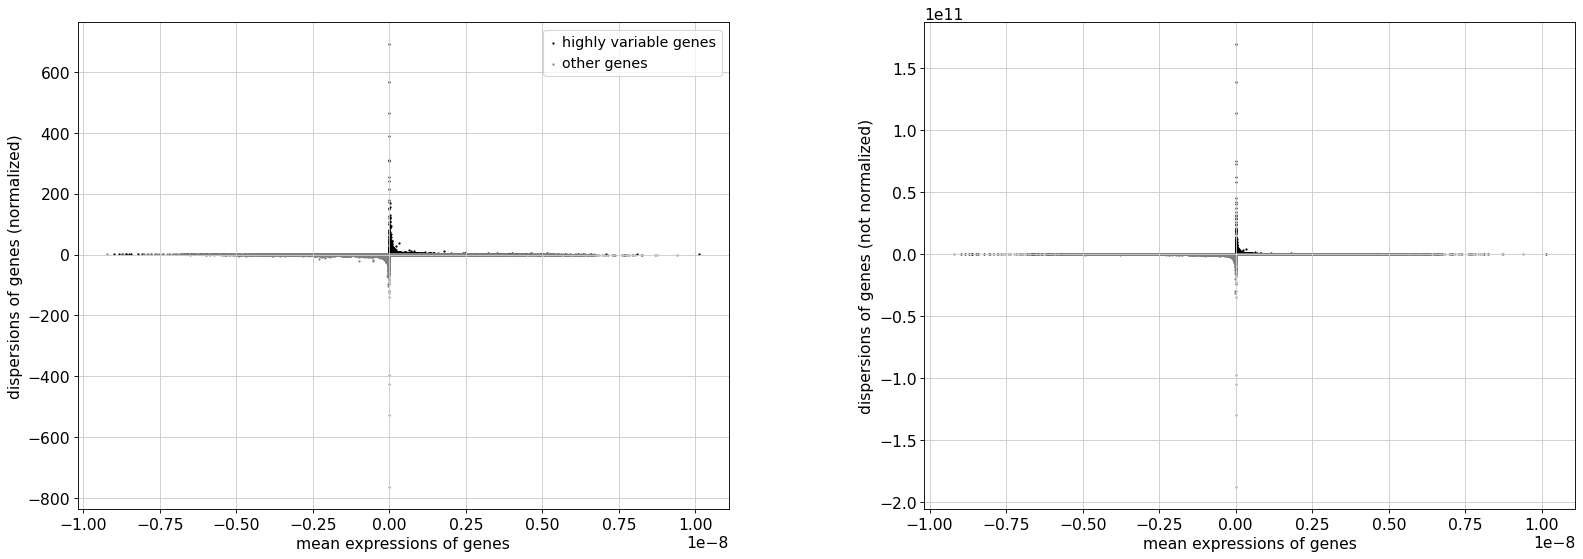

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
adata #this now only contains the most variable genes

AnnData object with n_obs × n_vars = 15355 × 14408
    obs: 'sample', 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [16]:
#Scale data 
sc.pp.scale(adata, max_value=10)

# 5) run harmony

In [17]:
# run PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


In [18]:
import scanpy.external as sce

sce.pp.harmony_integrate(adata, 'batch')

2021-08-27 01:34:52,996 - harmonypy - INFO - Iteration 1 of 10
2021-08-27 01:34:58,528 - harmonypy - INFO - Iteration 2 of 10
2021-08-27 01:35:03,597 - harmonypy - INFO - Iteration 3 of 10
2021-08-27 01:35:08,257 - harmonypy - INFO - Iteration 4 of 10
2021-08-27 01:35:12,853 - harmonypy - INFO - Iteration 5 of 10
2021-08-27 01:35:16,615 - harmonypy - INFO - Iteration 6 of 10
2021-08-27 01:35:19,787 - harmonypy - INFO - Iteration 7 of 10
2021-08-27 01:35:22,386 - harmonypy - INFO - Iteration 8 of 10
2021-08-27 01:35:24,810 - harmonypy - INFO - Iteration 9 of 10
2021-08-27 01:35:27,160 - harmonypy - INFO - Iteration 10 of 10
2021-08-27 01:35:29,814 - harmonypy - INFO - Stopped before convergence


In [19]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


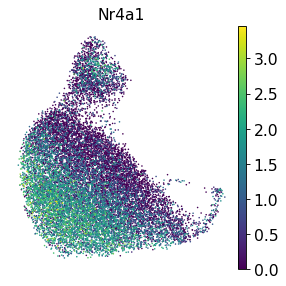

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


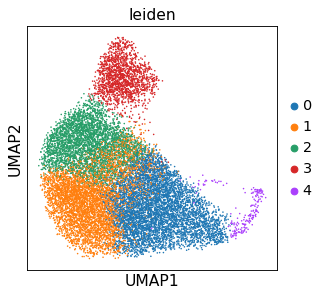

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


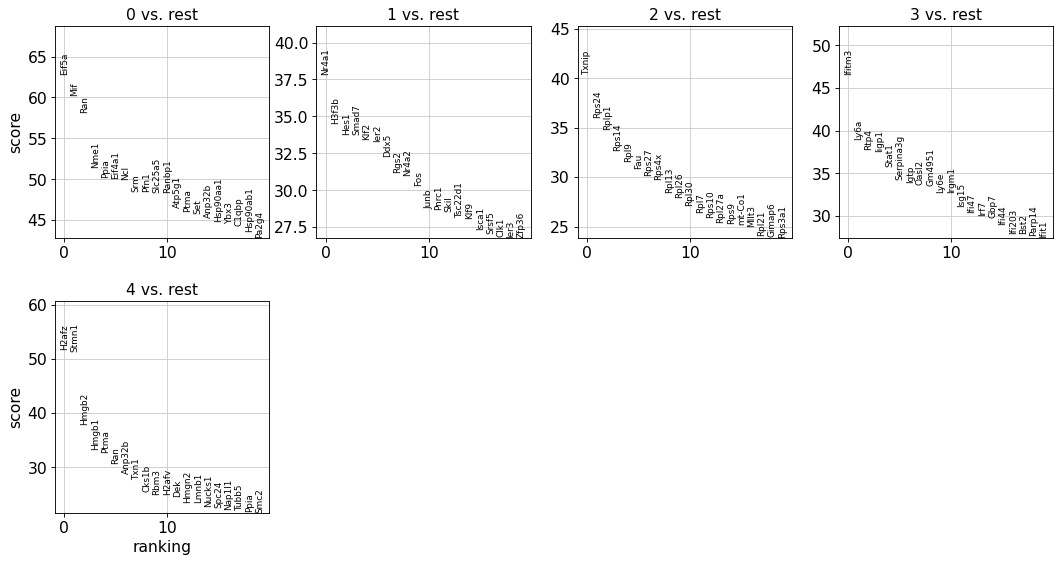

In [20]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=20, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


### Show sample distribution

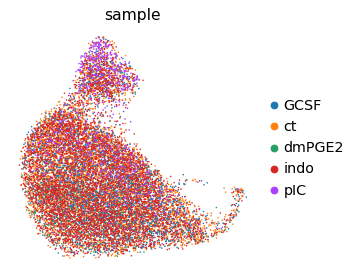

In [21]:
#see how the samples are overlapping

sc.pl.umap(adata, color=['sample'], frameon=False)

computing density on 'umap'
--> added
    'umap_density_sample', densities (adata.obs)
    'umap_density_sample_params', parameter (adata.uns)
/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1186: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  color_map.set_over('black')
/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1187: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  color_map.set_under('lightgray')
/opt/conda/l

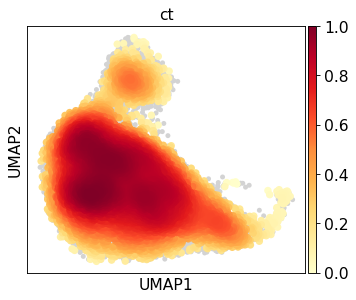

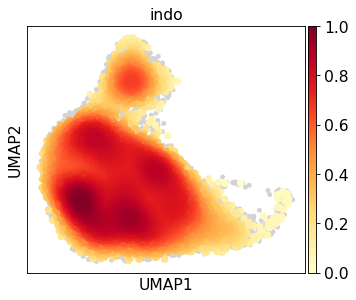

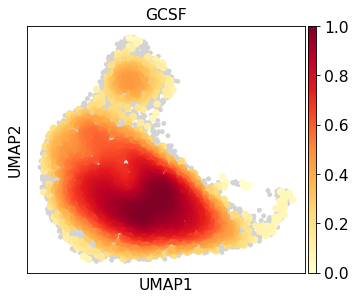

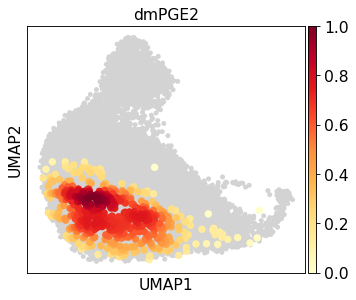

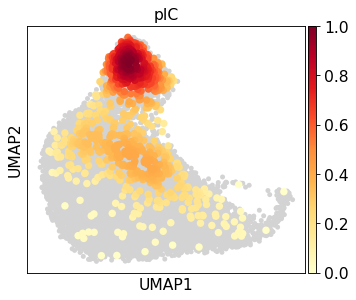

In [22]:
#see where samples localize

#Plot the density
sc.tl.embedding_density(adata, basis='umap', groupby='sample')

adata.obs['sample'].value_counts()
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='ct')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='indo')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='GCSF')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='dmPGE2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_sample', group='pIC')

In [23]:
sc.logging.print_versions()
pd.show_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.1.2
anyio               NA
argon2              20.1.0
attr                20.3.0
babel               2.9.1
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.04.1
dateutil            2.8.1
de